Análise do desempenho de Flamengo e Palmeiras: Libertadores 2025
Criado por: Anna Paula Barros da Silva.

Bibliotecas:

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import plotly.express as px



Leitura da tabela:

In [18]:
df = pd.read_csv('libertadores.csv')



Pasta de saída:

In [19]:
OUTPUT_DIR = 'sofascore_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)



Coluna de peso (para médias ponderadas)

In [20]:
if 'dweight' not in df.columns:
    df['dweight'] = 1
if 'pspwght' not in df.columns:
    df['pspwght'] = 1
df['peso'] = df['dweight'] * df['pspwght']

Métricas para o radar:

In [21]:
metrics = ['Finalizacoes', 'PassesChave', 'Desarmes', 'Interceptacoes', 'xG']


Função para radar do jogador:

In [22]:
def plot_radar(df, metrics, jogador, color='#FF0000'):
    if jogador not in df['Jogador'].values:
        print(f"Jogador {jogador} não encontrado no dataset.")
        return
    data_jog = df[df['Jogador'] == jogador][metrics].mean()
    categories = metrics
    N = len(categories)
    values = data_jog.tolist()
    values += values[:1]  
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=jogador, color=color)
    ax.fill(angles, values, color=color, alpha=0.25)
    plt.title(f'Desempenho: {jogador}')
    plt.legend(loc='upper right')
    plt.show()


Padronização das colunas:

In [23]:
df.rename(columns={
    'PassesChaves': 'PassesChave'
}, inplace=True)


radar do primeiro jogador do Flamengo:

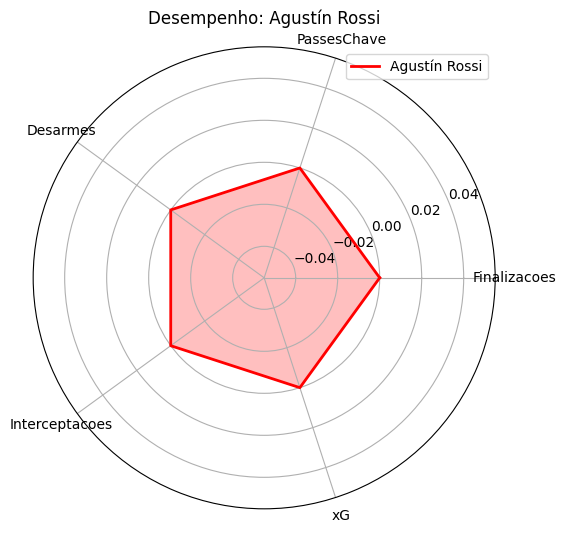

In [24]:
flamengo_first = df[df['Time']=='Flamengo']['Jogador'].iloc[0]
plot_radar(df, metrics, flamengo_first, color='#FF0000')

Média ponderada por time:

In [25]:
def weighted_avg(group, value_cols, weight_col='peso'):
    result = {}
    for col in value_cols:
        result[col] = np.average(group[col], weights=group[weight_col])
    return pd.Series(result)

team_metrics = df.groupby('Time').apply(weighted_avg, value_cols=metrics).reset_index()
team_metrics_melt = team_metrics.melt(id_vars='Time', var_name='Métrica', value_name='Valor')


C:\Users\annap\AppData\Local\Temp\ipykernel_21116\3256669346.py:7: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Cores dos times:

In [26]:
cores = {
    'Flamengo':'#FF0000',           
    'Flamengo (Reserva)':'#000000', 
    'Palmeiras':'#007A33',           
    'Palmeiras (Reserva)':'#CCCCCC' 
}





Gráfico de barras comparativo:

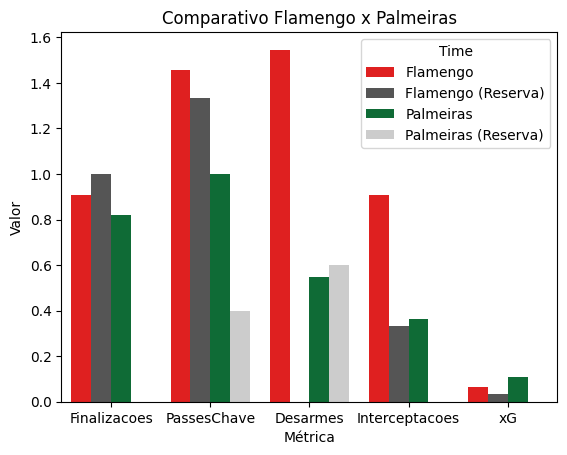

In [27]:
def generate_colors(times):
    base_colors = {
        'Flamengo':'#FF0000',
        'Palmeiras':'#007A33'
    }
    palette = {}
    for t in times:
        if '(Reserva)' in t:
            main = t.replace(' (Reserva)','')
            if main in base_colors:
                palette[t] = "#555555" if main=='Flamengo' else "#CCCCCC"
            else:
                palette[t] = "#AAAAAA"
        else:
            palette[t] = base_colors.get(t, "#888888")  # default cinza se não estiver no base_colors
    return palette

all_times = team_metrics_melt['Time'].unique()
cores = generate_colors(all_times)

sns.barplot(
    data=team_metrics_melt,
    x='Métrica',
    y='Valor',
    hue='Time',
    palette=cores
)
plt.title('Comparativo Flamengo x Palmeiras')
plt.show()



Heatmaps por zona:

In [28]:
if 'Zona' in df.columns:
    for time, cmap in zip(['Flamengo','Palmeiras'], ['Reds','Greens']):
        heatmap_data = df[df['Time']==time].groupby('Zona')['Finalizacoes'].sum().reset_index()
        heatmap_data_matrix = heatmap_data.pivot_table(index='Zona', values='Finalizacoes')
        sns.heatmap(heatmap_data_matrix, annot=True, cmap=cmap)
        plt.title(f'Heatmap de atuação {time}')
        plt.show()

Probabilidade de um chute resultar em gol:

In [29]:
xG_data = df.groupby(['MinutosJogados','Time'])['xG'].sum().reset_index()

fig = px.line(
    xG_data,
    x='MinutosJogados',
    y='xG',
    color='Time',
    title='Evolução do xG acumulado',
    labels={'xG':'xG','Time':'Time'},
    color_discrete_map=cores,
    markers=True
)
fig.show()
